# Простой вариант градиентного бустинга над регрессионными деревьями для случая квадратичной функции потерь

In [8]:
%matplotlib inline

import matplotlib
matplotlib.style.use('ggplot')

from matplotlib import pyplot
from matplotlib.colors import ListedColormap

from sklearn import datasets, ensemble, tree, model_selection, metrics
import xgboost as xgb

import numpy as np
import pandas as pd

from math import sqrt

import warnings
warnings.filterwarnings('ignore')

В качестве данных для демонстрации работы метода будет использоваться встроенный датасет `boston` из `sklearn.datasets`.
25% объектов выборки будет использовано для контроля качества.

In [2]:
# Загрузка датасета
boston = datasets.load_boston()

# Признаковое описание
X = boston.data

# Целевая функция
y = boston.target

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=0)

In [3]:
# Размер исходного датасета
print(X.shape, y.shape)

(506, 13) (506,)


In [4]:
# Размер обучающей и тестовой выборок
print(f'Обучающая выборка:\tX={X_train.shape} \t\tТестовая выборка:\tX={X_test.shape}')
print(f'\t\t\ty={y_train.shape} \t\t\t\t\ty={y_test.shape}')

Обучающая выборка:	X=(379, 13) 		Тестовая выборка:	X=(127, 13)
			y=(379,) 					y=(127,)


## 1. Случайный лес - описание, недостатки

`Случайный лес` — композиция глубоких деревьев, которые строятся независимо друг от друга. Но такой подход имеет следующую проблему. `Обучение глубоких деревьев требует очень много вычислительных ресурсов`, особенно в случае большой выборки или большого числа признаков.

Если ограничить глубину решающих деревьев в случайном лесе, то они уже не смогут улавливать сложные закономерности в данных. Это приведет к тому, что сдвиг будет слишком большим.

<img src="13.png" width=350 height=350>

В данном случае синий класс состоит из двух групп объектов, но неглубокое дерево смогло уловить только центральную группу. На объектах из второй группы такое дерево ошибается

Вторая проблема со случайным лесом состоит в том, что `процесс построения деревьев является ненаправленным`: каждое следующее дерево в композиции никак не зависит от предыдущих. Из-за этого для решения сложных задач необходимо огромное количество деревьев.

Решить данные проблемы можно с помощью так называемого _бустинга_.

## 2. Градиентный бустинг - описание

__Бустинг__ — это подход к построению композиций, в рамках которого:
* Базовые алгоритмы строятся последовательно, один за другим.
* Каждый следующий алгоритм строится таким образом, чтобы исправлять ошибки уже построенной композиции.

Благодаря тому, что построение композиций в бустинге является направленным, достаточно использовать простые базовые алгоритмы, например неглубокие деревья.

## 3. Градиентный бустинг - алгоритм

**Описание алгоритма градиентного бустинга**
1. __Инициализация__: инициализация композиции $a_0\left(x\right)=b_0\left(x\right)$, то есть построение простого алгоритма $b_0$.


2. __Шаг итерации__:

   2.1 __Вычисляется вектор сдвига__
$$s=-\nabla F=\left(\begin{matrix}{-L\prime}_z\left(y_1,\ a_{n-1}\left(x_1\right)\right)\\\cdots\\{-L\prime}_z\left(y_\ell,\ a_{n-1}\left(x_\ell\right)\right)\\\end{matrix}\right)$$
	2.2 __Строится алгоритм__
$$b_n\left(x\right)={argmin}_b\frac{1}{\ell}\sum_{i=1}^{\ell}\left(b\left(x_i\right)-s_i\right)^2$$
	2.3 __Алгоритм__ $b_n\left(x\right)$ __добавляется в композицию__
$$a_N\left(x\right)=a_{n-1}\left(x\right)+\eta b_n\left(x\right)$$

      где $\eta\in\left(\left.0,\ 1\right]\right.$ — длина шага. 
    
    
3. Если не выполнен критерий останова, то выполнить еще один шаг итерации. Если критерий останова выполнен, остановить итерационный процесс.


## 4. Градиентный бустинг в задаче регрессии

**Пусть дана задача регрессии, которую необходимо решить при помощи метода машинного обучения - градиентного бустинга**

__Функционал ошибки__ $Q\left(a,X\right)$ — ошибка прогноза $z$ некоторого алгоритма $a\left(x\right)$ на выборке из $\ell$ объектов $X=\left(x_i,\ y_i\right)_{i=1}^\ell$ относительно правильного ответа $y$.

Задача машинного обучения состоит в подборе такого алгоритма $a\left(x\right)$ из некоторого семейства алгоритмов $\mathbb{A}$, для которого достигается минимум функционала ошибки $Q\left(a,X\right)\rightarrow\min_{a\in\mathbb{A}}$

$$a\left(x\right)={argmin}_{a\in\mathbb{A}}Q\left(a,X\right)$$

Функционал ошибки измеряется функцией потерь, которая измеряет ошибку для одного объекта:

$$L\left(z,\ y\right) = L\left(a\left(x\right),\ y\right)$$

где: 
* $z$ — это прогноз алгоритма $a\left(x\right)$, 
* $y$ — истинный ответ на данном объекте. 

$$Q\left(a,x\right)=\frac{1}{\ell}\sum_{i=1}^{\ell}L\left(z_i,\ y_i\right)$$

Типичная функция ошибки в задачах регрессии — это среднеквадратичная ошибка алгоритма:

$$L\left(z,\ y\right) = \left(z-y\right)^2 = \left(a\left(x\right)-y\right)^2$$

Тогда функционал ошибки примет вид:

$$Q\left(a,X\right) = \frac{1}{\ell}\sum_{i=1}^{\ell}L\left(z_i,\ y_i\right) = \frac{1}{\ell}\sum_{i=1}^{\ell}\left(a\left(x_i\right)-y_i\right)^2$$

Для нахождения оптимальных параметров алгоритма $a\left(x\right)$ применим метод градиентного спуска, для чего необходимо сначала вычислить частные производные функции потерь:

$${L\prime}_z\left(y,\ z\right) = 2\left(z-y\right) = 2\left(a\left(x\right)-y\right)$$

Вычислим вектор сдвигов, каждая компонента которого показывает, как нужно модифицировать ответ на каждом объекте обучающей выборки, чтобы уменьшить среднеквадратичную ошибку:

$$s=-\nabla F=\left(\begin{matrix}{-L\prime}_z\left(y_1,\ a_{n-1}\left(x_1\right)\right)\\\cdots\\{-L\prime}_z\left(y_\ell,\ a_{n-1}\left(x_\ell\right)\right)\\\end{matrix}\right) = \left(\begin{matrix}- 2\left(a_{n-1}\left(x_1\right)-y_1\right)\\\cdots\\- 2\left(a_{n-1}\left(x_\ell\right)-y_\ell\right)\\\end{matrix}\right)$$

Для начала алгоритма градиентного бустинга необходимо обучить первый простой алгоритм (неглубокое решающее дерево):

$$b_0\left(x\right)={argmin}_b\frac{1}{\ell}\sum_{i=1}^{\ell}\left(b\left(x_i\right)-y_i\right)^2$$

In [9]:
def move_vector(z, y):
    """Возвращает частную производную для градиента функции"""
    return (- 1 * (z - y))


def dtc(X, y):
    """Возвращает обученный алгоритм"""
    return tree.DecisionTreeRegressor(max_depth=5, random_state=42).fit(X, y)


def gbm_predict(X):
    predictions = 0
    for coeff, algorithm in zip(coefficients_list, base_algorithms_list):
        predictions += coeff * algorithm.predict(X)
    return predictions

Вес перед каждым алгоритмом с каждой следующей итерацией уменьшается по формуле `0.9 / (1.0 + i)`, где `i` - номер итерации.

В реальности часто применяется следующая стратегия выбора шага: как только выбран алгоритм, подберем коэффициент перед ним численным методом оптимизации таким образом, чтобы отклонение от правильных ответов было минимальным.

train 1.0974978799443273
test 4.968891286623323


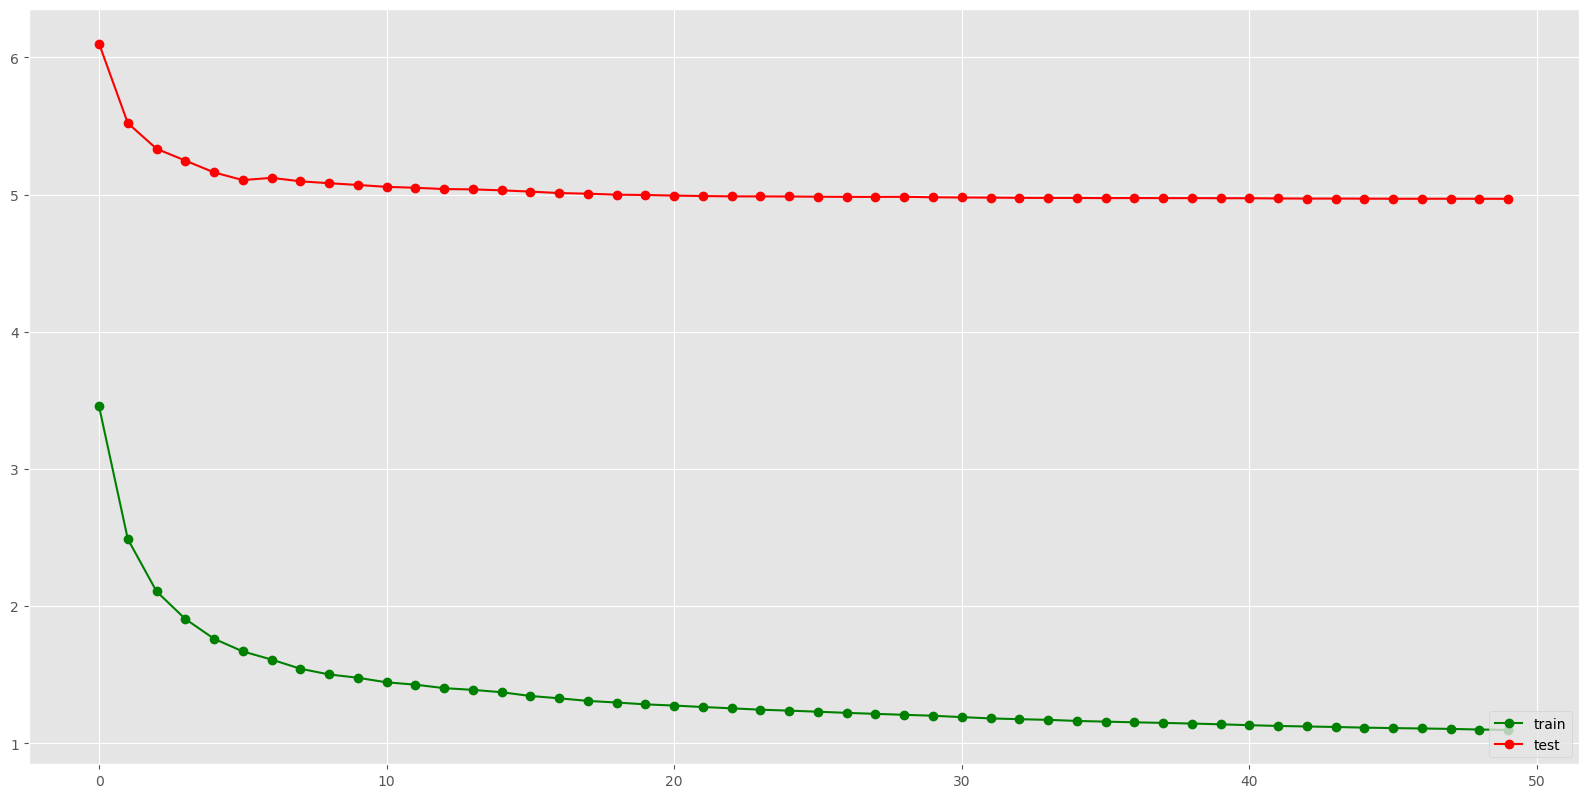

Wall time: 455 ms


In [12]:
%%time

base_algorithms_list = []
coefficients_list = []

train_quality = []
test_quality = []

n_trees = 50
s = y_train

for i in range(n_trees):

    # Смещенный алгоритм
    base_algorithm = dtc(X=X_train, y=s)
    base_algorithms_list.append(base_algorithm)
    
    # Коэффициент доверия базовому алгоритму 
    coeff = 0.9 / (1 + i)
    coefficients_list.append(coeff)
    
    # Предсказания композиции базовых алгоритмов  
    predictions = gbm_predict(X=X_train)
        
    # Вектор сдвига
    s = [move_vector(z, y) for z, y in zip(predictions, y_train)]
        
    # Оценка качества на обучающей выборке
    train_quality.append(sqrt(metrics.mean_squared_error(y_train, predictions)))
        
    # Оценка качества на тестовой выборке
    test_predictions = gbm_predict(X=X_test)
    test_quality.append(sqrt(metrics.mean_squared_error(y_test, test_predictions)))

# Оценка качества на обучающей выборке
predictions = gbm_predict(X=X_train)
print('train', sqrt(metrics.mean_squared_error(y_train, predictions)))
        
# Оценка качества на тестовой выборке
test_predictions = gbm_predict(X=X_test)
print('test', sqrt(metrics.mean_squared_error(y_test, test_predictions)))

# График распределения ошибки от количества деревьев в композиции
fig, nx = pyplot.subplots(figsize=(20,10), dpi=100)
pyplot.grid(True)
pyplot.plot(range(n_trees), train_quality, 'g-', marker='o', label='train')
pyplot.plot(range(n_trees), test_quality, 'r-', marker='o', label='test')
pyplot.legend(loc='lower right')
pyplot.show()

Реализованный метод - градиентный бустинг над деревьями - очень популярен в машинном обучении. Он представлен как в самой библиотеке `sklearn`, так и в сторонней библиотеке `XGBoost`, которая имеет свой питоновский интерфейс. На практике `XGBoost` работает заметно лучше `GradientBoostingRegressor` из `sklearn`.

### Зависимость качества работы алгоритма `sklearn.GradientBoostingRegressor` от количества деревьев

In [13]:
estimator = ensemble.GradientBoostingRegressor(max_depth=5, random_state=42, n_estimators=n_trees).fit(X=X_train, y=y_train)

In [14]:
print('test', sqrt(metrics.mean_squared_error(y_train, estimator.predict(X_train))))
print('test', sqrt(metrics.mean_squared_error(y_test, estimator.predict(X_test))))

test 0.6644574928139211
test 3.8260937629958525


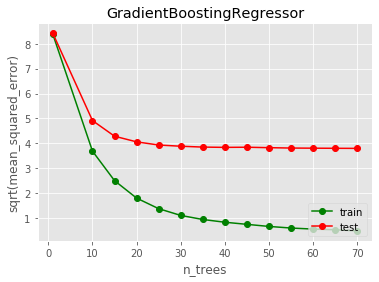

In [15]:
n_trees = [1] + list(range(10, 75, 5))

train_quality_list = []
test_quality_list = []


for n_tree in n_trees:
    # Модель градиентного бустинга
    estimator = ensemble.GradientBoostingRegressor(max_depth=5, random_state=42, n_estimators=n_tree)
    estimator.fit(X=X_train, y=y_train)
    
    # Качество на обучающей выборке
    train_quality = sqrt(metrics.mean_squared_error(y_train, estimator.predict(X_train)))
    train_quality_list.append(train_quality)
    
    # Качество на тестовой выборке
    test_quality = sqrt(metrics.mean_squared_error(y_test, estimator.predict(X_test)))
    test_quality_list.append(test_quality)
    

# График распределения ошибки от количества деревьев в композиции

pyplot.plot(n_trees, train_quality_list, 'g-', marker='o', label='train')
pyplot.plot(n_trees, test_quality_list, 'r-', marker='o', label='test')
pyplot.grid(True)
pyplot.xlabel('n_trees')
pyplot.ylabel('sqrt(mean_squared_error)')
pyplot.title('GradientBoostingRegressor')
pyplot.legend(loc='lower right')
pyplot.show()

С увеличением числа деревьев, начиная с некоторого момента, градиентный бустинг начинает переобучаться.

### Зависимость качества работы алгоритма `sklearn.GradientBoostingRegressor` от максимальной глубины деревьев

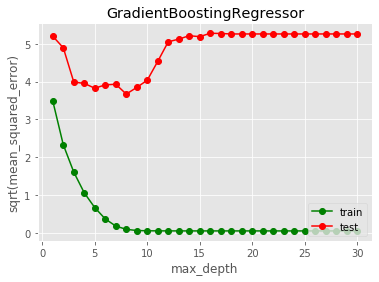

In [16]:
max_depths = list(range(1, 31, 1))

train_quality_list = []
test_quality_list = []


for max_depth in max_depths:
    # Модель градиентного бустинга
    estimator = ensemble.GradientBoostingRegressor(max_depth=max_depth, random_state=42, n_estimators=50)
    estimator.fit(X=X_train, y=y_train)
    
    # Качество на обучающей выборке
    train_quality = sqrt(metrics.mean_squared_error(y_train, estimator.predict(X_train)))
    train_quality_list.append(train_quality)
    
    # Качество на тестовой выборке
    test_quality = sqrt(metrics.mean_squared_error(y_test, estimator.predict(X_test)))
    test_quality_list.append(test_quality)
    

# График распределения ошибки от максимальной глубины деревьев в композиции

pyplot.plot(max_depths, train_quality_list, 'g-', marker='o', label='train')
pyplot.plot(max_depths, test_quality_list, 'r-', marker='o', label='test')
pyplot.grid(True)
pyplot.xlabel('max_depth')
pyplot.ylabel('sqrt(mean_squared_error)')
pyplot.title('GradientBoostingRegressor')
pyplot.legend(loc='lower right')
pyplot.show()

С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга на тестовой выборке начинает ухудшаться.

### Сравнение качества работы алгоритма градиентного бустинга качество с качеством работы линейной регрессии

In [17]:
from sklearn.linear_model import LinearRegression

In [18]:
# Создание объекта - модели линейной регресии
linear_regressor = LinearRegression()

# Обучение модели линейной регрессии
linear_regressor.fit(X_train, y_train)

# Предсказание значений целевой функции с помощью обученной модели
linear_predictions = linear_regressor.predict(X_test)

# Оценка качества на тестовой выборке
print('test', sqrt(metrics.mean_squared_error(y_test, linear_predictions)))

test 5.457311159564066
